# Imports

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from bindsnet.network import Network
from bindsnet.network.nodes import LIFNodes, AdaptiveLIFNodes, Input
from bindsnet.network.monitors import Monitor
from bindsnet.network.topology import Connection
from bindsnet.analysis.plotting import plot_spikes, plot_voltages
import importlib, utils
importlib.reload(utils)
from utils import create_diagonal_connection, create_clustered_connection, visualize_weight_matrix
from utils import visualize_weight_matrix, create_clustered_connection_with_density, plot_network_activity

# Small test network

In [101]:
time = 100
source_layer = Input(n=100)
input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()
print(input_data)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)


In [102]:
network = Network()

In [103]:
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from torchvision import transforms as T

# Initialize data encoder and dataset
encoder = PoissonEncoder(time=100)  # Time duration of the spike trains (in ms)

# torchvision transform: PIL -> torch.Tensor in [0,1], then flatten to 784
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x.view(-1)),  # 784
])

# Simple identity encoder for labels (BindsNET wrapper expects a callable)
class IdentityEncoder:
    def __call__(self, x):
        return x

DATA_ROOT = './data'
train_dataset = MNIST(
    image_encoder=encoder,
    label_encoder=IdentityEncoder(),
    root=DATA_ROOT,
    download=True,
    train=True,
    transform=transform,
)

test_dataset = MNIST(
    image_encoder=encoder,
    label_encoder=IdentityEncoder(),
    root=DATA_ROOT,
    download=True,
    train=False,
    transform=transform,
)

# Get a single sample (BindsNET wrapper returns a dict)
sample = train_dataset[0]
encoded_image, label = sample["encoded_image"], sample["label"]
print(encoded_image.shape)  # e.g., torch.Size([100, 784])
print(label)


torch.Size([100, 784])
5


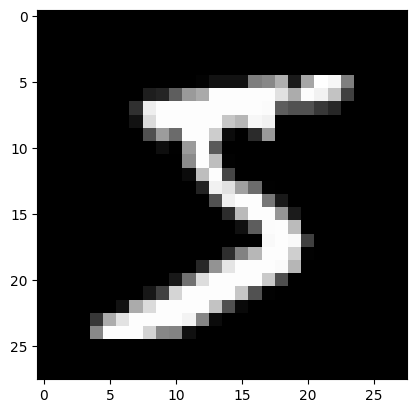

In [104]:
image = np.array(sample["image"]).reshape(28, 28)
plt.imshow(image, cmap='gray')
plt.show()

In [105]:
# Network
net = Network(dt=1.0)

inp    = Input(n=100)                 # spike source
adlif1 = AdaptiveLIFNodes(n=100)      # spiking layer

net.add_layer(inp, name="Input")
net.add_layer(adlif1, name="AdLIF 1")

w_lat_np = utils.create_clustered_connection_with_density(100, 25, window_size=1, weight=1.0, weight_probability=1, density=1, distance_metric="manhattan", distance_scale=5)
w_lat = torch.from_numpy(w_lat_np)
net.add_connection(Connection(source=inp, target=adlif1, w=w_lat), source="Input", target="AdLIF 1")
net.add_connection(Connection(source=adlif1, target=adlif1, w=w_lat), source="AdLIF 1", target="AdLIF 1")

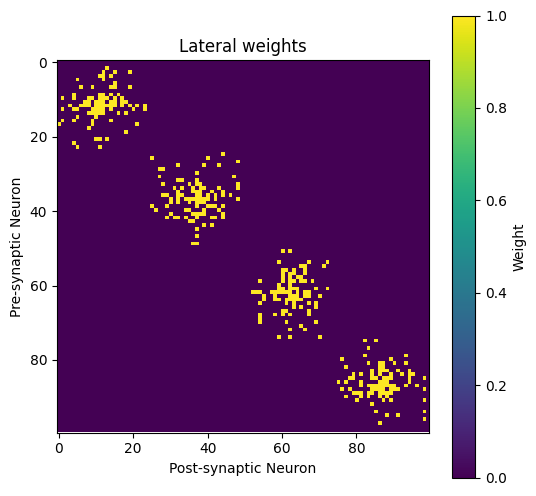

In [106]:
visualize_weight_matrix(w_lat_np, title="Lateral weights")

In [107]:
input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()

# add monitors

In [108]:
input_monitor = Monitor(obj=inp, state_vars=["s"], time=time)
adlif1_monitor = Monitor(obj=adlif1, state_vars=["s", "v"], time=time)
net.add_monitor(input_monitor, name="Input")
net.add_monitor(adlif1_monitor, name="AdLIF 1")

In [109]:
net.run(inputs={"Input": input_data}, time=time)

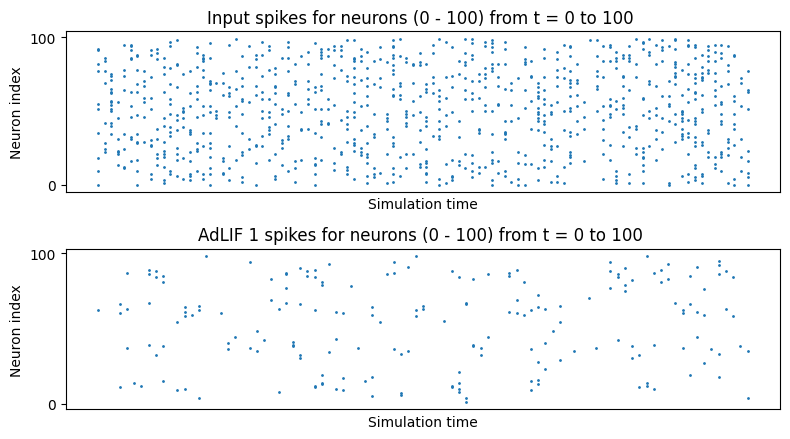

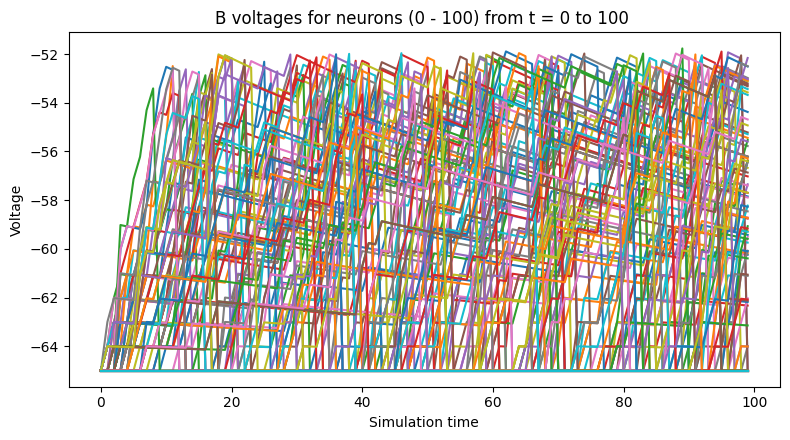

In [110]:
spikes = {
    "Input": input_monitor.get("s"), "AdLIF 1": adlif1_monitor.get("s")
}
voltages = {"B": adlif1_monitor.get("v")}

plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()

torch.Size([100, 100]) torch.Size([100, 100])


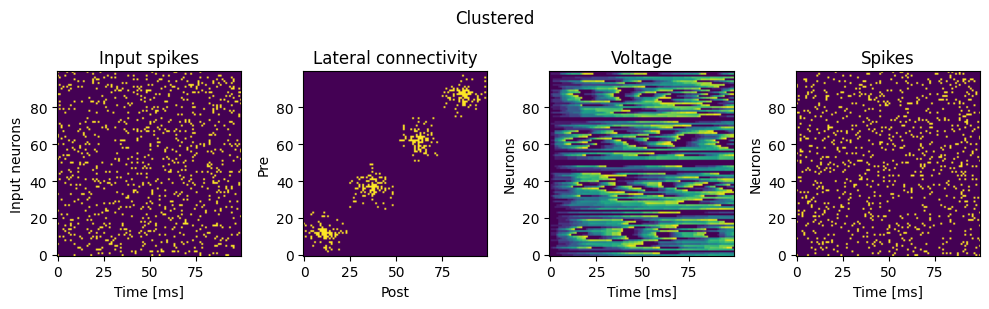

In [111]:
s = input_monitor.get("s").squeeze(1)  # [T, n_neurons]
v = adlif1_monitor.get("v").squeeze(1)  # [T, n_neurons]
print(s.shape, v.shape)
plot_network_activity(input_data, w_lat, v.T, s.T, title='Clustered', sub_titles=["Input spikes", "Lateral connectivity",
                                                                                                              "Voltage", "Spikes"])

In [ ]:
adlif2 = AdaptiveLIFNodes(n=100)      # spiking layer
net.add_layer(adlif2, name="AdLIF 2")
w_lat2 = create_clustered_connection_with_density(100, 25, window_size=1, weight=1.0, weight_probability=1, density=1, distance_metric="manhattan", distance_scale=5)
w_lat2 = torch.from_numpy(w_lat2)
adlif2_ff = Connection(source=adlif1, target=adlif2)
net.add_connection(adlif2_ff, source="AdLIF 1", target="AdLIF 2")
adlif2_monitor = Monitor(obj=adlif2, state_vars=["s", "v"], time=time)
net.add_monitor(adlif2_monitor, name="AdLIF 2")
net.run(inputs={"Input": input_data}, time=time)

torch.Size([100, 100]) torch.Size([100, 100])


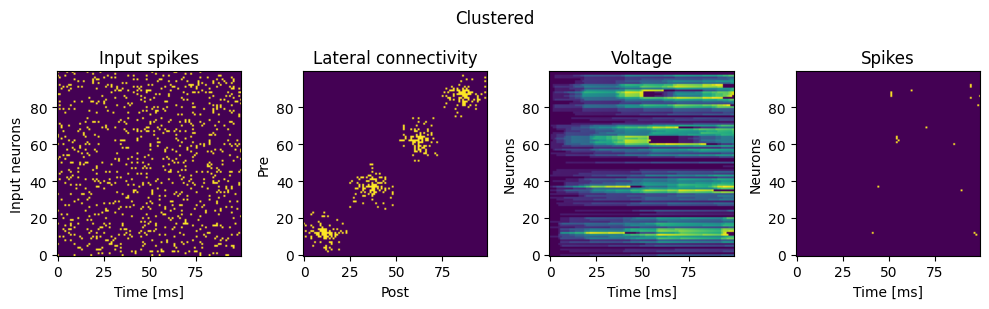

In [114]:
# Visualize results
s = adlif2_monitor.get("s").squeeze(1)  # [T, n_neurons]
v = adlif2_monitor.get("v").squeeze(1)  # [T, n_neurons]
print(s.shape, v.shape)
plot_network_activity(input_data, w_lat, v.T, s.T, title='Clustered', sub_titles=["Input spikes", "Lateral connectivity",
                                                                                                              "Voltage", "Spikes"])